# Explore TM-Align Results

In [ ]:
import pandas as pd
results = pd.read_parquet('tmalign_rmsd_full.parquet').sort_values(by=['tm_score_norm_ref_p1'], ascending=False)
tm_score_threshold = 0.5
rmsd_threshold = 3
# Scores below 0.17 correspond to randomly chosen unrelated proteins whereas structures with a score higher than 0.5 assume generally the same fold in SCOP/CATH. (Zhang)
# Quantitative study shows that proteins of TM-score = 0.5 have a posterior probability of 37% in the same CATH topology family and of 13% in the same SCOP fold family. 
# The probabilities increase rapidly when TM-score > 0.5. (Wikipedia)
print('Num. Results:', len(results))

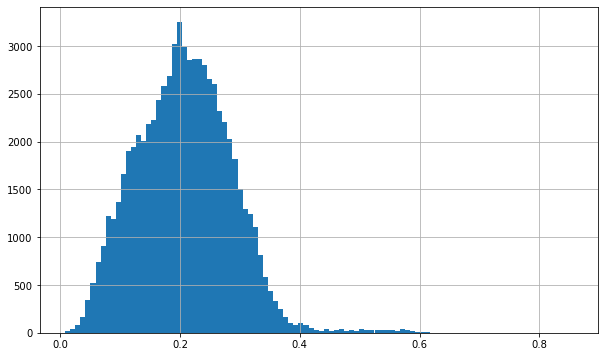

In [756]:
results.tm_score_norm_ref_p1.astype(float).hist(bins=100, figsize=(10,6));

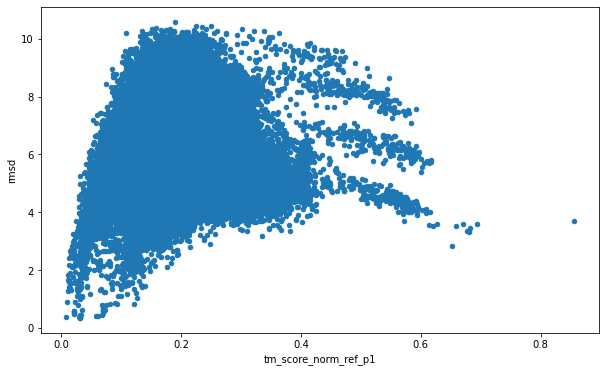

In [757]:
results[['rmsd', 'tm_score_norm_ref_p1']].astype(float).plot(x='tm_score_norm_ref_p1', y='rmsd', kind='scatter', figsize=(10,6));

In [758]:
results[results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold]

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tm_score_norm_ref_p1
0,AF-Q9NW08-F1-model_v1,1133,AF-Q9H9Y6-F1-model_v1,1135,1054,3.69,0.85502
0,AF-Q8N1S5-F1-model_v1,342,AF-Q13433-F1-model_v1,755,278,3.59,0.69422
0,AF-Q8N1S5-F1-model_v1,342,AF-Q6P5W5-F1-model_v1,647,279,3.47,0.68158
0,AF-Q8N1S5-F1-model_v1,342,AF-Q504Y0-F1-model_v1,691,269,3.31,0.6798
0,AF-Q8N1S5-F1-model_v1,342,AF-Q9BRY0-F1-model_v1,314,273,3.36,0.67734
...,...,...,...,...,...,...,...
0,AF-Q8N1S5-F1-model_v1,342,AF-Q12802-F1-model_v1,12413,273,6.35,0.50196
0,AF-Q8N1S5-F1-model_v1,342,AF-P78509-F1-model_v1,12642,274,6.12,0.50181
0,AF-Q8N1S5-F1-model_v1,342,AF-P46939-F1-model_v1,12392,275,6.32,0.50092
0,AF-P48449-F1-model_v1,732,AF-Q07954-F1-model_v1,12910,592,8.32,0.50053


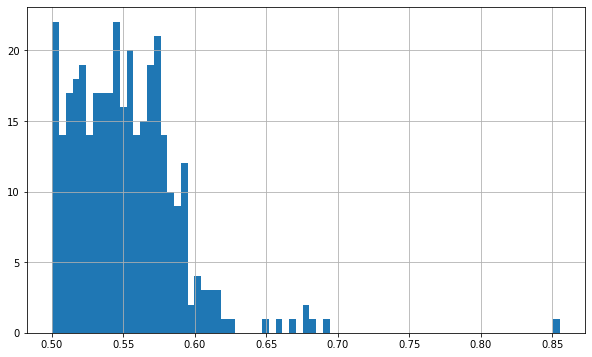

In [759]:
results[results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold].tm_score_norm_ref_p1.astype(float).hist(bins=75, figsize=(10,6));

In [760]:
# We used three different RMSD classifications for docking solutions: (a) good solution when RMSD ≤ 2.0 Å [8,22], (b) acceptable solutions when RMSD is between 2.0 and 3.0 Å, and (c) bad solutions when RMSD ≥ 3.0 Å. 
# https://www.mdpi.com/1420-3049/23/5/1038/htm
results[(results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold) & (results.rmsd.astype(float) < rmsd_threshold)]

,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tm_score_norm_ref_p1
0,AF-Q8N1S5-F1-model_v1,342,AF-Q9NUM3-F1-model_v1,307,254,2.84,0.65136


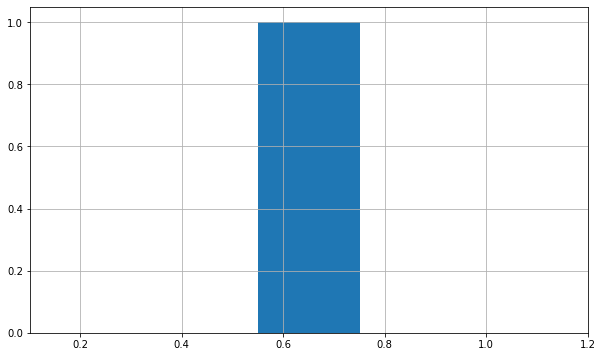

In [761]:
results[(results.tm_score_norm_ref_p1.astype(float) > tm_score_threshold) & (results.rmsd.astype(float) <= rmsd_threshold)].tm_score_norm_ref_p1.astype(float).hist(bins=5, figsize=(10,6));

# TM-Align Function

In [5]:
import io
import os
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from google.cloud import storage
from multiprocessing import Pool
import random
import pandas as pd

In [6]:
# generates protein combinations, runs tmalign on each, and saves results into a df

def process_report(p1, p2, pld):
    aligned_length, rmsd, tm_score_norm_ref_p1, p1_length, p2_length = 0,0,0,0,0
    result = []
    for line in pld:
        if 'Aligned length' in line:
            bits = line.split(',')
            aligned_length = int(''.join([n for n in bits[0] if n in '.0123456789']))
            rmsd = float(''.join([n for n in bits[1] if n in '.0123456789']))
        if 'normalized by length of Chain_1' in line:
            bits = line.split('=')
            tm_score_norm_ref_p1 = float(''.join([n for n in bits[1][:10] if n in '.0123456789']))
        if 'Length of Chain_1' in line:
            p1_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
        if 'Length of Chain_2' in line:
            p2_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
    result = [p1, p1_length, p2, p2_length, aligned_length, rmsd, tm_score_norm_ref_p1]
    return result


def tmalign(pairs_and_labels, chunk=0):
    '''
    Accepts an n x 3 (query protein, target protein and cluster label) or n x 2 array (query protein and target protein).
    Returns an n x 8 array with original inputs and TM-Align stats for each pair of proteins in the input array. Also writes
    results to pairs_tmalign_rmsd.parquet.
    
    NOTE: The parquet writing is broken at the moment due to multithreading, but the return results is 100% correct, so just
    write your results to file outside this function.
    '''
    result = []
    names = ['query_protein', 'query_protein_length', 'target_protein',
             'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score']
    for pair in pairs_and_labels:
        if pair[0] != pair[1]:
            cmd = f'/home/jupyter/pss/tmalign/TMalign /home/jupyter/pss/final_pdbs/{pair[0]}.pdb /home/jupyter/pss/final_pdbs/{pair[1]}.pdb'
            tmalign_report = os.popen(cmd).readlines()
            result.append(process_report(pair[0], pair[1], tmalign_report))
            if pairs_and_labels.shape[1] > 2:
                result[-1].append(pair[2])
    if pairs_and_labels.shape[1] > 2:
        names.append('cluster')
    chunk = random.randint(0, 100000)
    table = pa.Table.from_pandas(pd.DataFrame(result, columns=names))
    pq.write_table(table, f'tmp/pairs_tmalign_rmsd_{str(chunk)}.parquet')
    return result

In [3]:
# test data for functions

combinations = np.array([['AF-Q8N1S5-F1-model_v1', 'AF-Q13433-F1-model_v1'], ['AF-Q8N1S5-F1-model_v1', 'AF-Q9ULF5-F1-model_v1']])
print(tmalign(combinations))

[['AF-Q8N1S5-F1-model_v1', 342, 'AF-Q13433-F1-model_v1', 755, 278, 3.59, 0.69422], ['AF-Q8N1S5-F1-model_v1', 342, 'AF-Q9ULF5-F1-model_v1', 831, 270, 3.58, 0.66977]]


In [7]:
def download_file(path):
        data=[]
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
        storage_client = storage.Client()
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path)
        blob.download_to_filename(path.split('/')[-1])

        
#download_file('samples/all_protein_combos_per_cluster.parquet')
#pd.read_parquet('all_protein_combos_per_cluster.parquet').head()

In [12]:
combos = pd.read_parquet('all_protein_combos_per_cluster.parquet')
combos.query_protein = 'AF-' + combos.query_protein.astype(str) + '-F1-model_v1'
combos.target_protein = 'AF-' + combos.target_protein.astype(str) + '-F1-model_v1'
test_combos = combos[['query_protein', 'target_protein', 'cluster']].values

In [ ]:
# SINGLE THREAD (SLOWER)

start = time.time()
answer = tmalign(test_combos)
print(f"took {int(time.time() - start)} seconds")
print(f'Sent {len(test_combos)} records and got back {len(answer)}.')
pd.read_parquet('pairs_tmalign_rmsd_0.parquet').sample(10)

In [769]:
# OPTIMIZED OVER DEEPFOLD (FASTEST)

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[start::int(size / num_threads)+1] for start in range(int(size / num_threads)+1)]))
    
print(f"took {int(time.time() - start)} seconds")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(10)

table = pa.Table.from_pandas(res)
pq.write_table(table, f'pairs_tmalign_rmsd_merged.parquet')

took 3 seconds
Sent 25 records and got back 25.


# Production Run

model_outputs/A1-DBSCAN-DeepFold-cluster_stats.parquet

model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[IN PROGRESS]**

model_outputs/A1-DBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**

model_outputs/B1-HDBSCAN-DeepFold-cluster_stats.parquet

model_outputs/B2-HDBSCAN-SeqVec-cluster_stats.parquet

model_outputs/A2-DBSCAN-SeqVec-all_protein_combos_per_cluster.parquet **[DONE]**

model_outputs/B1-HDBSCAN-DeepFold-all_protein_combos_per_cluster.parquet **[DONE]**

model_outputs/A2-DBSCAN-SeqVec-cluster_stats.parquet


In [8]:
# Get the experiment data

# DeepFold + DBSCAN
home = '/home/jupyter/pss/'
file = 'model_outputs/B2-HDBSCAN-SeqVec-all_protein_combos_per_cluster.parquet'

download_file(file)

model = pd.read_parquet(home + file.split('/')[-1])
model.query_protein = 'AF-' + model.query_protein.astype(str) + '-F1-model_v1'
model.target_protein = 'AF-' + model.target_protein.astype(str) + '-F1-model_v1'
print(len(model))
model.head()

174584


,query_protein,target_protein,cluster
1,AF-O96009-F1-model_v1,AF-P00797-F1-model_v1,0
2,AF-O96009-F1-model_v1,AF-P07339-F1-model_v1,0
3,AF-O96009-F1-model_v1,AF-P0DJD7-F1-model_v1,0
4,AF-O96009-F1-model_v1,AF-P0DJD8-F1-model_v1,0
5,AF-O96009-F1-model_v1,AF-P0DJD9-F1-model_v1,0


In [9]:
# First get all the tmaligm stats we already computed

batch_stats = pd.read_parquet('pairwise_evaluation_metrics.parquet')
print(len(batch_stats))
batch_stats.head()

218997


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [10]:
# If we already have stats for the pair, save it; run tmalign on the remainder

# First join to batch stats
batch_stats.set_index(['query_protein', 'target_protein'], inplace=True)
model.set_index(['query_protein', 'target_protein'], inplace=True)
model_stats = model.join(batch_stats, on=['query_protein', 'target_protein'], how='left')

In [11]:
# Only focus on novel pairs we've never seen to date; also find clusters with more than 200 pairs
test_combos = model_stats[model_stats.rmsd.isna()].reset_index()
x = test_combos.groupby(['cluster']).count().reset_index()
big_clusters = x[x.query_protein > 200].cluster.values
big_clusters

array([  1,   5,   8,  11,  12,  26,  30,  86,  87,  88,  90, 102, 106,
       111, 115, 118, 123, 124, 131, 138, 139, 140, 143, 147, 163, 170,
       171, 181, 186, 209, 211, 219, 224, 226, 233, 241, 242, 243, 245,
       249, 269, 272, 273, 278, 292, 295, 299, 304, 312, 318, 320, 326,
       328, 349, 355, 356, 358, 360, 367, 371, 378, 380, 394, 396, 402,
       405, 418, 419, 421, 423, 432, 436, 438, 445, 455, 457, 464, 465,
       477, 481, 484, 487, 493, 504, 513, 534, 535, 545, 548, 560, 564,
       568, 574, 578, 579, 580, 591, 599, 604, 618, 620, 633, 635, 645,
       658, 667, 675, 676, 694, 701, 708, 709, 716, 720, 724, 726, 735,
       743, 753, 755])

In [12]:
# Downsample big clusters (> 200 pairs) to 25%
big_cluster_samples = pd.DataFrame(None, columns=x.columns)

for cluster in big_clusters:
    sliced = test_combos[test_combos.cluster == cluster]
    big_cluster_samples = big_cluster_samples.append(sliced.sample(int(len(sliced) * 0.25)))

big_cluster_samples

,cluster,query_protein,target_protein,query_protein_length,target_protein_length,aligned_length,rmsd,tmalign_score
117,1,AF-A0A075B6Y3-F1-model_v1,AF-A0A075B706-F1-model_v1,NaN,NaN,NaN,NaN,NaN
477,1,AF-A0A0J9YXM7-F1-model_v1,AF-A0A075B6Y9-F1-model_v1,NaN,NaN,NaN,NaN,NaN
446,1,AF-A0A0J9YWX3-F1-model_v1,AF-A0A0J9YXG5-F1-model_v1,NaN,NaN,NaN,NaN,NaN
451,1,AF-A0A0J9YWX3-F1-model_v1,AF-A0N4Z7-F1-model_v1,NaN,NaN,NaN,NaN,NaN
396,1,AF-A0A0C4DH63-F1-model_v1,AF-A0A0A0MT94-F1-model_v1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
154185,755,AF-Q13535-F1-model_v1,AF-Q9H2T7-F1-model_v1,NaN,NaN,NaN,NaN,NaN
150268,755,AF-Q5SRE5-F1-model_v1,AF-Q9NR09-F1-model_v1,NaN,NaN,NaN,NaN,NaN
147513,755,AF-Q8TEL6-F1-model_v1,AF-Q9Y6B7-F1-model_v1,NaN,NaN,NaN,NaN,NaN
149447,755,AF-O60518-F1-model_v1,AF-Q9HAV4-F1-model_v1,NaN,NaN,NaN,NaN,NaN


In [13]:
# Recombine small clusters with big cluster samples
test_combos = test_combos[~test_combos.cluster.isin(big_clusters)].append(big_cluster_samples)

In [14]:
# generate array for tmalign
test_combos = test_combos.values
len(test_combos)

61296

In [15]:
# remove pairs with known giant protein
known_giant_proteins = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/merged_pdbs/')]
zmp = []
for pair in test_combos:
    if pair[0] in known_giant_proteins or pair[1] in known_giant_proteins:
        continue
    else:
        zmp.append(pair)
test_combos = np.array(zmp)
len(test_combos)

59684

In [ ]:
# run tmalign and save chunked results to parquet files

import time

names = ['query_protein', 'query_protein_length', 'target_protein',
         'target_protein_length', 'aligned_length', 'rmsd', 'tmalign_score', 'cluster']
size = len(test_combos)
step = 500
h = []
num_threads = os.cpu_count() - 1
np.random.shuffle(test_combos)

start = time.time()

with Pool(num_threads) as p:
    h.append(p.map(tmalign, [test_combos[i*step:(i+1)*step] for i in range(int(size / step + 1))]))
    
print(f"Took {int((time.time() - start) / 60)} minutes.")

res = []
for a in h:
    for b in a:
        for c in b:
            res.append(c)

res = pd.DataFrame(res, columns=names)        
print(f'Sent {len(test_combos)} records and got back {len(res)}.')
res.sample(10)